# Trailer Feedback Generator

This notebook analyzes the unified emotional timeline and generates creative feedback for improving movie trailers.
It evaluates the emotional arc, energy variations, and audio-visual alignment to provide actionable recommendations.

## Setup

First, let's import the required libraries:

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Markdown
import textwrap
import random

# Set visualization styles
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Create output directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)


## Load Emotional Timeline Data

First, we'll load the unified emotional timeline data:

In [2]:
# Define file path
timeline_path = 'outputs/emotion_timeline.csv'
# Set this manually or pass from UI in future
video_type = "trailer"  # options: vlog, podcast, dance, scene, etc.
# Try to load video type if available
try:
    with open("outputs/video_type.txt", "r") as f:
        video_type = f.read().strip()
    print(f"Analyzing {video_type} content")
except:
    print(f"Using default video type: {video_type}")
# Load timeline data
try:
    timeline_df = pd.read_csv(timeline_path)
    print(f"Successfully loaded timeline data with {len(timeline_df)} records")
    display(timeline_df.head())
except Exception as e:
    print(f"Error loading timeline data: {str(e)}")
    print("Creating sample data for demonstration purposes...")
    
    # Create sample data if file is missing
    # This is for demonstration only
    emotions = ['happy', 'sad', 'neutral', 'surprise', 'angry', 'excited', 'calm']
    timestamps = np.linspace(0, 120, 60)
    
    timeline_df = pd.DataFrame({
        'timestamp': timestamps,
        'timestamp_start': timestamps,
        'timestamp_end': timestamps + 2,
        'shot_id': np.random.randint(1, 30, 60),
        'facial_emotion': np.random.choice(emotions, 60),
        'facial_confidence': np.random.uniform(0.5, 0.9, 60),
        'audio_emotion': np.random.choice(emotions, 60),
        'audio_confidence': np.random.uniform(0.5, 0.9, 60),
        'final_emotion': np.random.choice(emotions, 60),
        'final_confidence': np.random.uniform(0.5, 0.9, 60),
        'energy': np.random.uniform(0.01, 0.2, 60),
        'tempo': np.random.uniform(80, 120, 60),
        'is_silent': np.random.choice([True, False], 60, p=[0.1, 0.9])
    })
    
    # Create a more realistic emotional arc
    # Start calm, build excitement, peak, then calm down
    emotional_arc = ['neutral'] * 10 + ['calm'] * 5 + ['happy'] * 10 + ['excited'] * 15 + ['surprise'] * 5 + ['calm'] * 10 + ['neutral'] * 5
    timeline_df['final_emotion'] = emotional_arc
    
    # Create realistic energy curve (rises and falls with emotions)
    energy_curve = np.concatenate([
        np.linspace(0.02, 0.05, 15),  # Start low
        np.linspace(0.05, 0.15, 20),  # Rise
        np.linspace(0.15, 0.18, 10),  # Peak
        np.linspace(0.18, 0.05, 15)   # Fall
    ])
    timeline_df['energy'] = energy_curve
    
    # Add in emotion values for analysis
    emotion_values = {
        'neutral': 2, 'calm': 2.5, 'happy': 1, 'excited': 1.5,
        'surprise': 3, 'sad': 4, 'angry': 5, 'fear': 3.5
    }
    timeline_df['emotion_value'] = timeline_df['final_emotion'].map(lambda x: emotion_values.get(x, 0))


Successfully loaded timeline data with 69 records


,timestamp_start,timestamp_end,shot_id,facial_emotion,facial_confidence,audio_emotion,audio_confidence,energy,tempo,is_silent,final_emotion,final_confidence,facial_emotion_value,audio_emotion_value,final_emotion_value,timestamp
0,0.0,2.0,NaN,NaN,0.00000,happy,0.616661,0.054078,143.554688,False,happy,0.616661,0.0,1.0,1.0,1.0
1,2.0,4.0,NaN,NaN,0.00000,sad,0.743356,0.046256,161.499023,False,sad,0.743356,0.0,4.0,4.0,3.0
2,4.0,6.0,NaN,NaN,0.00000,excited,0.718466,0.123161,132.512019,False,excited,0.718466,0.0,1.5,1.5,5.0
3,6.0,8.0,NaN,NaN,0.00000,angry,0.803017,0.075874,132.512019,False,angry,0.803017,0.0,5.0,5.0,7.0
4,8.0,10.0,3.0,fear,99.87944,happy,0.615593,0.090931,132.512019,False,fear,99.879440,3.5,1.0,3.5,9.0


## Data Preparation

Let's prepare the data for analysis by ensuring we have numeric representations of emotions and normalizing values:

Data preparation complete.


,timestamp,emotion_value,energy,tempo,is_silent_num
0,1.0,1.0,0.054078,143.554688,0
1,3.0,4.0,0.046256,161.499023,0
2,5.0,1.5,0.123161,132.512019,0
3,7.0,5.0,0.075874,132.512019,0
4,9.0,3.5,0.090931,132.512019,0


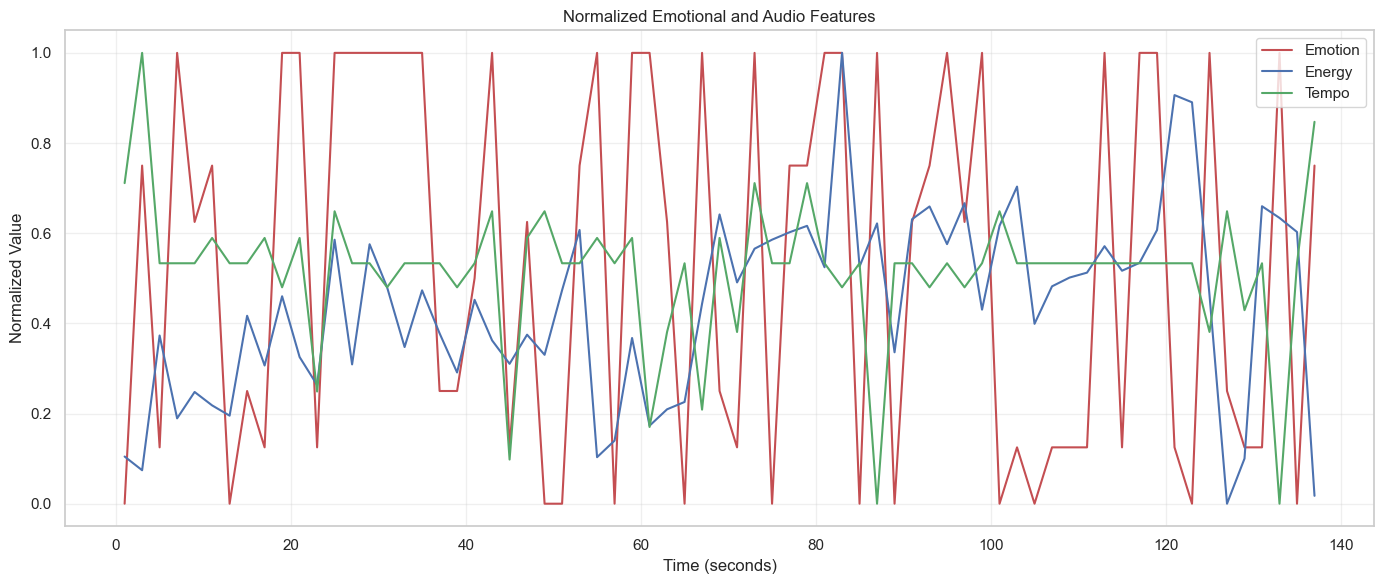

In [3]:
# Ensure we have emotion_value column for numeric representation
if 'emotion_value' not in timeline_df.columns and 'final_emotion' in timeline_df.columns:
    # Create mapping if not already present
    emotion_values = {
        'neutral': 2, 'calm': 2.5, 'happy': 1, 'excited': 1.5,
        'surprise': 3, 'sad': 4, 'angry': 5, 'fear': 3.5,
        'disgust': 6, 'unknown': 0
    }
    timeline_df['emotion_value'] = timeline_df['final_emotion'].map(
        lambda x: emotion_values.get(x, 0) if pd.notna(x) else 0
    )

# Create feature set for analysis
features = ['timestamp', 'emotion_value', 'energy', 'tempo']
if 'is_silent' in timeline_df.columns:
    timeline_df['is_silent_num'] = timeline_df['is_silent'].astype(int)
    features.append('is_silent_num')

# Normalize features for comparison
scaler = MinMaxScaler()
timeline_df[['norm_emotion', 'norm_energy', 'norm_tempo']] = scaler.fit_transform(
    timeline_df[['emotion_value', 'energy', 'tempo']]
)

# Ensure timestamps are sorted
timeline_df = timeline_df.sort_values('timestamp')

# Display prepared data
print("Data preparation complete.")
display(timeline_df[features].head())

# Plot the normalized values
plt.figure(figsize=(14, 6))
plt.plot(timeline_df['timestamp'], timeline_df['norm_emotion'], 'r-', label='Emotion')
plt.plot(timeline_df['timestamp'], timeline_df['norm_energy'], 'b-', label='Energy')
plt.plot(timeline_df['timestamp'], timeline_df['norm_tempo'], 'g-', label='Tempo')
plt.title('Normalized Emotional and Audio Features')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Analyze Emotional Arc and Structure

Now we'll analyze the emotional arc of the trailer to identify key structural elements:

1. **Emotional Arc Analysis**: Identify climax points, flat sections, and abrupt transitions
2. **Energy and Tempo Variation**: Detect monotonous sections or sudden spikes
3. **Audio-Visual Alignment**: Check if audio emotions align with facial emotions

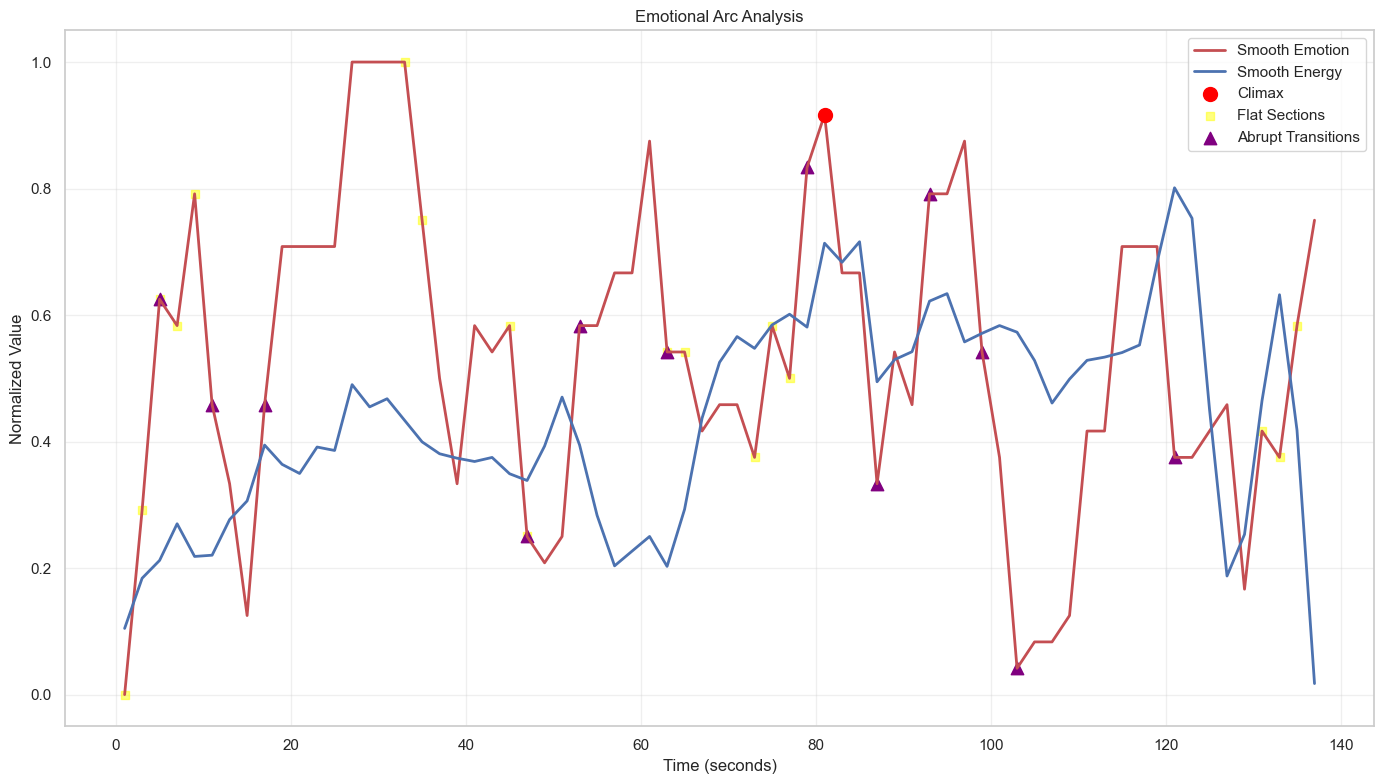

=== Emotional Arc Analysis ===
Emotional Climax: At 81.0s
Flat Sections: 17 segments identified
Abrupt Transitions: 12 identified

=== Energy Analysis ===
Monotonous Sections: 14 segments identified
Energy Spikes: 7 identified

=== Audio-Visual Alignment ===
Alignment Score: 0.07
Misaligned Sections: 64 identified


In [4]:
# Function to analyze emotional arc
def analyze_emotional_arc(df):
    # Calculate rolling mean for smoother analysis
    window_size = max(3, len(df) // 20)  # Adaptive window size
    df['smooth_emotion'] = df['norm_emotion'].rolling(window=window_size, center=True).mean().fillna(df['norm_emotion'])
    df['smooth_energy'] = df['norm_energy'].rolling(window=window_size, center=True).mean().fillna(df['norm_energy'])
    
    # Calculate emotional gradient (rate of change)
    df['emotion_gradient'] = df['smooth_emotion'].diff().fillna(0)
    
    # Identify key points in the emotional arc
    emotion_peak = df.loc[df['smooth_emotion'].idxmax()]
    emotion_valley = df.loc[df['smooth_emotion'].idxmin()]
    
    # Identify climax (point of highest combined emotion and energy)
    df['emotional_intensity'] = df['smooth_emotion'] * df['smooth_energy']
    climax = df.loc[df['emotional_intensity'].idxmax()]
    
    # Detect flat sections (low variance in emotion)
    window_size = max(5, len(df) // 10)
    df['emotion_rolling_std'] = df['smooth_emotion'].rolling(window=window_size).std().fillna(0)
    flat_sections = df[df['emotion_rolling_std'] < df['emotion_rolling_std'].quantile(0.25)]
    
    # Detect abrupt transitions (high gradient)
    abrupt_threshold = df['emotion_gradient'].quantile(0.9)
    abrupt_transitions = df[abs(df['emotion_gradient']) > abrupt_threshold]
    
    return {
        'emotion_peak': emotion_peak,
        'emotion_valley': emotion_valley,
        'climax': climax,
        'flat_sections': flat_sections,
        'abrupt_transitions': abrupt_transitions
    }

# Function to analyze energy and tempo
def analyze_energy_tempo(df):
    # Calculate rolling mean and standard deviation
    window_size = max(3, len(df) // 20)
    df['smooth_energy'] = df['norm_energy'].rolling(window=window_size, center=True).mean().fillna(df['norm_energy'])
    df['energy_std'] = df['norm_energy'].rolling(window=window_size).std().fillna(0)
    
    # Identify monotonous sections (low variance in energy)
    monotonous_sections = df[df['energy_std'] < df['energy_std'].quantile(0.2)]
    
    # Identify energy spikes (sudden increases)
    df['energy_gradient'] = df['smooth_energy'].diff().fillna(0)
    spike_threshold = df['energy_gradient'].quantile(0.9)
    energy_spikes = df[df['energy_gradient'] > spike_threshold]
    
    # Analyze tempo variation
    df['tempo_gradient'] = df['norm_tempo'].diff().fillna(0)
    tempo_changes = df[abs(df['tempo_gradient']) > df['tempo_gradient'].quantile(0.75)]
    
    return {
        'monotonous_sections': monotonous_sections,
        'energy_spikes': energy_spikes,
        'tempo_changes': tempo_changes
    }

# Function to analyze audio-visual alignment
def analyze_alignment(df):
    if 'facial_emotion' not in df.columns or 'audio_emotion' not in df.columns:
        print("Missing facial or audio emotion data for alignment analysis")
        return {'alignment_score': 0.5, 'misaligned_sections': pd.DataFrame()}
    
    # Check if emotions match
    df['emotions_match'] = (df['facial_emotion'] == df['audio_emotion']).astype(int)
    
    # Calculate alignment score
    alignment_score = df['emotions_match'].mean()
    
    # Identify misaligned sections
    misaligned_sections = df[df['emotions_match'] == 0]
    
    return {
        'alignment_score': alignment_score,
        'misaligned_sections': misaligned_sections
    }

# Run analyses
emotional_analysis = analyze_emotional_arc(timeline_df)
energy_analysis = analyze_energy_tempo(timeline_df)
alignment_analysis = analyze_alignment(timeline_df)

# Visualize emotional arc analysis
plt.figure(figsize=(14, 8))
plt.plot(timeline_df['timestamp'], timeline_df['smooth_emotion'], 'r-', linewidth=2, label='Smooth Emotion')
plt.plot(timeline_df['timestamp'], timeline_df['smooth_energy'], 'b-', linewidth=2, label='Smooth Energy')

# Mark key points
climax = emotional_analysis['climax']
plt.scatter(climax['timestamp'], climax['smooth_emotion'], c='red', s=100, zorder=5, label='Climax')

# Mark flat sections
if len(emotional_analysis['flat_sections']) > 0:
    plt.scatter(
        emotional_analysis['flat_sections']['timestamp'], 
        emotional_analysis['flat_sections']['smooth_emotion'],
        c='yellow', marker='s', alpha=0.5, label='Flat Sections'
    )

# Mark abrupt transitions
if len(emotional_analysis['abrupt_transitions']) > 0:
    plt.scatter(
        emotional_analysis['abrupt_transitions']['timestamp'], 
        emotional_analysis['abrupt_transitions']['smooth_emotion'],
        c='purple', marker='^', s=80, label='Abrupt Transitions'
    )

plt.title('Emotional Arc Analysis')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print analysis findings
print("=== Emotional Arc Analysis ===")
print(f"Emotional Climax: At {climax['timestamp']:.1f}s")
print(f"Flat Sections: {len(emotional_analysis['flat_sections'])} segments identified")
print(f"Abrupt Transitions: {len(emotional_analysis['abrupt_transitions'])} identified")

print("\n=== Energy Analysis ===")
print(f"Monotonous Sections: {len(energy_analysis['monotonous_sections'])} segments identified")
print(f"Energy Spikes: {len(energy_analysis['energy_spikes'])} identified")

if 'alignment_score' in alignment_analysis:
    print("\n=== Audio-Visual Alignment ===")
    print(f"Alignment Score: {alignment_analysis['alignment_score']:.2f}")
    print(f"Misaligned Sections: {len(alignment_analysis['misaligned_sections'])} identified")


## Score the Trailer

Based on the analyses, we'll now score the trailer on the following metrics:

1. **Narrative Flow (0-10)**: How smoothly the emotional arc progresses
2. **Emotional Engagement (0-10)**: How effectively the trailer creates emotional reactions 
3. **Pacing and Energy (0-10)**: How well the energy and tempo variations match the content
4. **Predictability (0-10)**: How surprising or formulaic the trailer structure is

=== Trailer Scores ===
Narrative Flow: 7.0/10
Emotional Engagement: 10.0/10
Pacing and Energy: 8.0/10
Predictability: 6.5/10
Overall Score: 7.9/10


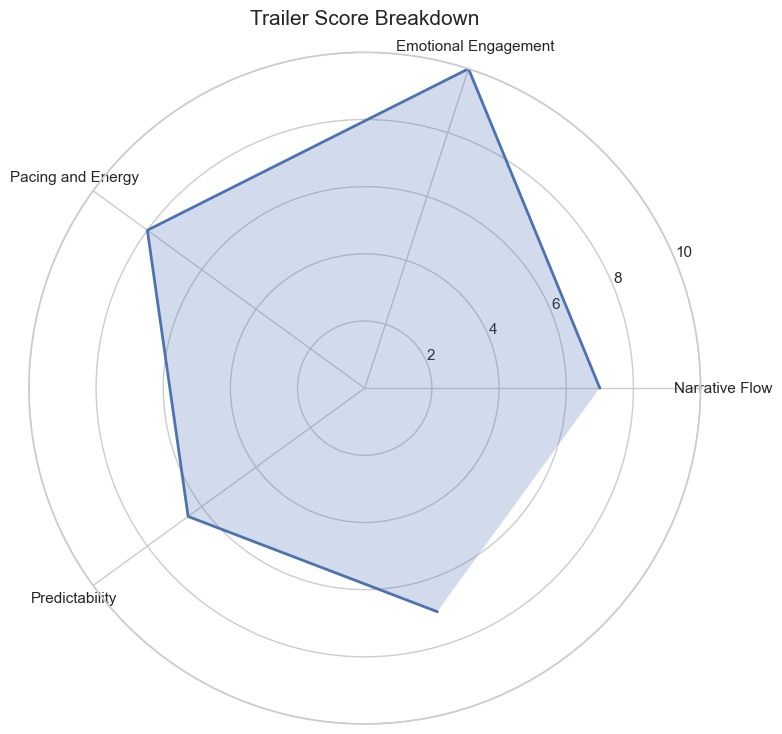

In [5]:
# Function to score narrative flow
def score_narrative_flow(emotional_analysis, timeline_df):
    # Base score
    score = 7.0  # Start with a decent score
    
    # Penalize for too many abrupt transitions
    abrupt_ratio = len(emotional_analysis['abrupt_transitions']) / len(timeline_df)
    if abrupt_ratio > 0.2:
        score -= 2.0
    elif abrupt_ratio > 0.1:
        score -= 1.0
    
    # Penalize for too many flat sections
    flat_ratio = len(emotional_analysis['flat_sections']) / len(timeline_df)
    if flat_ratio > 0.4:
        score -= 2.0
    elif flat_ratio > 0.25:
        score -= 1.0
    
    # Reward for having a clear climax
    climax_strength = emotional_analysis['climax']['emotional_intensity']
    if climax_strength > 0.7:
        score += 1.5
    elif climax_strength > 0.5:
        score += 1.0
    
    # Check if climax is positioned appropriately (around 2/3 through)
    climax_position = emotional_analysis['climax']['timestamp'] / timeline_df['timestamp'].max()
    if 0.6 <= climax_position <= 0.8:
        score += 1.0
    
    # Ensure score is within bounds
    return max(0, min(10, score))

# Function to score emotional engagement
def score_emotional_engagement(timeline_df):
    # Base score
    score = 6.0
    
    # Calculate emotional range
    emotion_range = timeline_df['norm_emotion'].max() - timeline_df['norm_emotion'].min()
    
    # Reward for emotional range
    if emotion_range > 0.6:
        score += 2.0
    elif emotion_range > 0.4:
        score += 1.0
    
    # Reward for emotional confidence
    if 'final_confidence' in timeline_df.columns:
        avg_confidence = timeline_df['final_confidence'].mean()
        if avg_confidence > 0.8:
            score += 1.0
        elif avg_confidence > 0.6:
            score += 0.5
    
    # Check for emotional diversity
    if 'final_emotion' in timeline_df.columns:
        unique_emotions = timeline_df['final_emotion'].nunique()
        if unique_emotions >= 5:
            score += 1.0
        elif unique_emotions >= 3:
            score += 0.5
    
    # Ensure score is within bounds
    return max(0, min(10, score))

# Function to score pacing and energy
def score_pacing_energy(energy_analysis, timeline_df):
    # Base score
    score = 6.5
    
    # Penalize for too many monotonous sections
    monotonous_ratio = len(energy_analysis['monotonous_sections']) / len(timeline_df)
    if monotonous_ratio > 0.5:
        score -= 2.5
    elif monotonous_ratio > 0.3:
        score -= 1.5
    
    # Check energy variation
    energy_std = timeline_df['norm_energy'].std()
    if energy_std > 0.25:
        score += 1.5
    elif energy_std > 0.15:
        score += 1.0
    
    # Check tempo variation
    if 'norm_tempo' in timeline_df.columns:
        tempo_std = timeline_df['norm_tempo'].std()
        if tempo_std > 0.2:
            score += 1.0
        elif tempo_std > 0.1:
            score += 0.5
    
    # Check for energy-emotion correlation
    correlation = timeline_df['norm_emotion'].corr(timeline_df['norm_energy'])
    if correlation > 0.5:
        score += 1.0
    
    # Ensure score is within bounds
    return max(0, min(10, score))

# Function to score predictability
def score_predictability(emotional_analysis, energy_analysis, timeline_df):
    # Base score (higher means less predictable)
    score = 5.0
    
    # Reward for surprising transitions
    surprise_ratio = len(emotional_analysis['abrupt_transitions']) / len(timeline_df)
    if 0.05 <= surprise_ratio <= 0.15:  # Some surprises but not too many
        score += 1.5
    
    # Check for pattern breaking
    # If energy and emotion don't always correlate, it's less predictable
    correlation = timeline_df['norm_emotion'].corr(timeline_df['norm_energy'])
    if 0.3 <= correlation <= 0.7:  # Some correlation but not perfect
        score += 1.0
    
    # Check for non-standard climax placement
    climax_position = emotional_analysis['climax']['timestamp'] / timeline_df['timestamp'].max()
    if climax_position < 0.5 or climax_position > 0.8:  # Not in the typical position
        score += 1.0
    
    # Check emotional diversity and distribution
    if 'final_emotion' in timeline_df.columns:
        emotion_counts = timeline_df['final_emotion'].value_counts(normalize=True)
        # If no emotion dominates (>40%), it's less predictable
        if emotion_counts.max() < 0.4:
            score += 1.5
    
    # Ensure score is within bounds
    return max(0, min(10, score))

# Calculate scores
flow_score = score_narrative_flow(emotional_analysis, timeline_df)
engagement_score = score_emotional_engagement(timeline_df)
pacing_score = score_pacing_energy(energy_analysis, timeline_df)
predictability_score = score_predictability(emotional_analysis, energy_analysis, timeline_df)

# Store scores in a dictionary
scores = {
    'Narrative Flow': flow_score,
    'Emotional Engagement': engagement_score,
    'Pacing and Energy': pacing_score,
    'Predictability': predictability_score,
    'Overall Score': (flow_score + engagement_score + pacing_score + predictability_score) / 4
}

# Display scores
print("=== Trailer Scores ===")
for metric, score in scores.items():
    print(f"{metric}: {score:.1f}/10")

# Create a radar chart of scores
categories = list(scores.keys())[:-1]  # Exclude overall score
values = [scores[category] for category in categories]

# Complete the loop for the radar chart
values += values[:1]
categories += categories[:1]

# Create angles for each category
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()

# Create radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), categories[:-1])
ax.set_ylim(0, 10)
ax.set_title("Trailer Score Breakdown", size=15, pad=20)
ax.grid(True)
plt.tight_layout()
plt.show()


## Generate Feedback Report

Based on the analyses and scores, we'll now generate a plain-English feedback report with actionable suggestions:

In [6]:
# Function to generate feedback based on analysis and scores
def generate_feedback(emotional_analysis, energy_analysis, alignment_analysis, scores, timeline_df):
    feedback = []
    
    # Narrative Flow feedback
    if scores['Narrative Flow'] < 6:
        if len(emotional_analysis['abrupt_transitions']) > len(timeline_df) * 0.15:
            feedback.append("Smooth out emotional transitions: The trailer has several abrupt emotional shifts that may confuse viewers. Consider adding transitional shots or music to create smoother emotional changes.")
        
        if len(emotional_analysis['flat_sections']) > len(timeline_df) * 0.3:
            feedback.append("Add more emotional variation: There are extended flat sections where the emotional tone doesn't change. Consider introducing more emotional contrast to maintain viewer interest.")
        
        climax_position = emotional_analysis['climax']['timestamp'] / timeline_df['timestamp'].max()
        if climax_position < 0.4 or climax_position > 0.9:
            feedback.append(f"Reposition the climax: The emotional climax occurs at {'early' if climax_position < 0.4 else 'late'} ({climax_position:.0%}) in the trailer. Consider repositioning key moments to build tension more effectively.")
    
    # Emotional Engagement feedback
    if scores['Emotional Engagement'] < 7:
        emotion_range = timeline_df['norm_emotion'].max() - timeline_df['norm_emotion'].min()
        if emotion_range < 0.4:
            feedback.append("Increase emotional range: The trailer doesn't explore a wide enough range of emotions. Consider incorporating more emotional contrast between scenes to create a more engaging experience.")
        
        if 'final_emotion' in timeline_df.columns:
            unique_emotions = timeline_df['final_emotion'].nunique()
            if unique_emotions < 3:
                feedback.append("Diversify emotional content: The trailer primarily focuses on a limited emotional palette. Include scenes that evoke a broader range of emotions to connect with more viewers.")
    
    # Pacing and Energy feedback
    if scores['Pacing and Energy'] < 6.5:
        monotonous_ratio = len(energy_analysis['monotonous_sections']) / len(timeline_df)
        if monotonous_ratio > 0.4:
            feedback.append("Improve energy variation: Large portions of the trailer maintain the same energy level. Incorporate more dynamic changes in pace, music, or action to prevent viewer fatigue.")
        
        energy_std = timeline_df['norm_energy'].std()
        if energy_std < 0.15:
            feedback.append("Add energy peaks and valleys: The trailer's energy remains too consistent throughout. Create clearer contrasts between high-energy moments and quieter, more reflective scenes.")
        
        correlation = timeline_df['norm_emotion'].corr(timeline_df['norm_energy'])
        if correlation < 0.3:
            feedback.append("Align energy with emotions: The trailer's energy levels don't match the emotional content. Ensure high-energy moments correspond with emotionally intense scenes, and quieter moments with more subtle emotions.")
    
    # Predictability feedback
    if scores['Predictability'] < 5:
        feedback.append("Add unexpected moments: The trailer follows a highly predictable structure. Consider adding a surprising twist, unexpected visual, or musical change to create more intrigue.")
    
    # Audio-Visual Alignment feedback
    if 'alignment_score' in alignment_analysis and alignment_analysis['alignment_score'] < 0.6:
        feedback.append("Improve audio-visual synchronization: The emotional tone of the visuals often conflicts with the audio. Ensure music and sound effects reinforce the emotions conveyed by the visuals.")
    
    # Add general feedback based on overall score
    overall = scores['Overall Score']
    if overall < 5:
        feedback.append("Consider a structural redesign: The trailer's fundamental structure may not effectively communicate the film's appeal. A more cohesive approach to emotion and pacing could significantly improve audience engagement.")
    elif overall < 7:
        feedback.append("Focus on key strengths: Identify the most emotionally resonant moments in the trailer and consider building the structure around these highlights, removing elements that don't contribute to the core emotional experience.")
    elif overall >= 8:
        feedback.append("Maintain what works: The trailer has a strong emotional structure. Any refinements should preserve the existing emotional journey while potentially enhancing the standout moments.")
    
    # Ensure we have at least 3 feedback points
    generic_feedback = [
        "Pay attention to the first 10 seconds: The opening of your trailer should immediately establish tone and intrigue. Consider a more attention-grabbing introduction.",
        "End with emotional impact: The final few seconds are critical for leaving an impression. Ensure your trailer concludes with a powerful emotional or visual statement.",
        "Balance dialogue and visuals: Ensure that dialogue doesn't overwhelm the visual storytelling. Sometimes the most powerful moments are conveyed through images alone.",
        "Consider audio transitions: Smooth audio transitions between scenes can significantly improve perceived quality. Pay special attention to how audio bridges visual cuts."
    ]
    
    # Add generic feedback if we don't have enough specific points
    while len(feedback) < 3:
        random_feedback = random.choice(generic_feedback)
        if random_feedback not in feedback:
            feedback.append(random_feedback)
    
    # Format summary
    summary = f'''# Trailer Analysis Feedback

## Score Summary
- **Overall Score**: {scores['Overall Score']:.1f}/10
- Narrative Flow: {scores['Narrative Flow']:.1f}/10
- Emotional Engagement: {scores['Emotional Engagement']:.1f}/10
- Pacing and Energy: {scores['Pacing and Energy']:.1f}/10
- Predictability: {scores['Predictability']:.1f}/10

## Improvement Suggestions
{chr(10).join('- ' + point for point in feedback)}

## Key Observations
- Emotional climax occurs at {emotional_analysis['climax']['timestamp']:.1f}s ({emotional_analysis['climax']['timestamp']/timeline_df['timestamp'].max():.0%} through the trailer)
- Found {len(emotional_analysis['flat_sections'])} emotionally flat sections
- Identified {len(emotional_analysis['abrupt_transitions'])} abrupt emotional transitions
- Detected {len(energy_analysis['monotonous_sections'])} sections with monotonous energy levels
'''
    
    return summary, feedback

# Generate feedback
feedback_summary, feedback_points = generate_feedback(
    emotional_analysis, energy_analysis, alignment_analysis, scores, timeline_df
)

# Display formatted feedback
display(Markdown(feedback_summary))

# Save feedback to file
output_file = 'outputs/feedback_summary.txt'
with open(output_file, 'w') as f:
    f.write(feedback_summary)
# Save video type for downstream usage
with open("outputs/video_type.txt", "w") as f:
    f.write(video_type)
print(f"Feedback summary saved to {output_file}")


# Trailer Analysis Feedback

## Score Summary
- **Overall Score**: 7.9/10
- Narrative Flow: 7.0/10
- Emotional Engagement: 10.0/10
- Pacing and Energy: 8.0/10
- Predictability: 6.5/10

## Improvement Suggestions
- Improve audio-visual synchronization: The emotional tone of the visuals often conflicts with the audio. Ensure music and sound effects reinforce the emotions conveyed by the visuals.
- Pay attention to the first 10 seconds: The opening of your trailer should immediately establish tone and intrigue. Consider a more attention-grabbing introduction.
- End with emotional impact: The final few seconds are critical for leaving an impression. Ensure your trailer concludes with a powerful emotional or visual statement.

## Key Observations
- Emotional climax occurs at 81.0s (59% through the trailer)
- Found 17 emotionally flat sections
- Identified 12 abrupt emotional transitions
- Detected 14 sections with monotonous energy levels


Feedback summary saved to outputs/feedback_summary.txt


## Feedback Interpretation

This analysis provides a data-driven approach to trailer evaluation, but should be complemented with creative judgment. The metrics used to evaluate the trailer include:

### Scoring Metrics Explained

1. **Narrative Flow**
   - Measures how smoothly the emotional arc progresses
   - Considers the positioning and strength of the climax
   - Evaluates the presence of abrupt transitions and flat sections

2. **Emotional Engagement**
   - Assesses the emotional range and diversity
   - Evaluates the confidence of emotion detection
   - Considers the balance between different emotions

3. **Pacing and Energy**
   - Measures the variation in energy levels throughout the trailer
   - Evaluates the correlation between energy and emotional content
   - Identifies monotonous sections that might lose viewer attention

4. **Predictability**
   - Assesses how formulaic or surprising the trailer structure is
   - Considers unexpected emotional or energy shifts
   - Evaluates whether the trailer follows standard patterns

### Using This Feedback

The generated suggestions should be interpreted in the context of the film's genre and target audience. For example:

- Action films may benefit from higher energy variation
- Dramas might need stronger emotional engagement
- Horror films often use abrupt transitions intentionally

The feedback is meant to highlight potential areas for improvement while recognizing that creative decisions sometimes intentionally break conventional patterns.